In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import biophysnn
import motifscanner
import scipy.stats
import seaborn as sns

from importlib import reload
reload(biophysnn)

<module 'biophysnn' from '/gpfs/commons/home/daknowles/pooledRBPs/biophysical_cnn/biophysnn.py'>

In [2]:
dat_file = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/enrichment_values/all_data_gencode_v41_300w_100s.txt.gz"
dat = pd.read_csv(dat_file, sep = "\t")
dat.rename(columns={"X1":"chrom","X2":"start","X3":"end","X4":"gene","X6":"strand"}, inplace=True)
dat

In [10]:
dat.iloc[:,-8:].sum(0)

CW30154-hnrnpk     176895383
CW30154-input      212786538
hnrnpa1-rep1      1191470049
hnrnpk-rep1       1299814470
hnrnpk-rep2        877928296
input-rep1        1363084884
input-rep2        1359492001
rbfox2-rep2       1148823603
dtype: int64

In [4]:
IP_col = "hnrnpk-rep1"
input_col = "input-rep1"

In [15]:
total_count_threshold = 30
dat_sub = dat[dat.loc[:,[IP_col,input_col]].sum(1) > total_count_threshold]

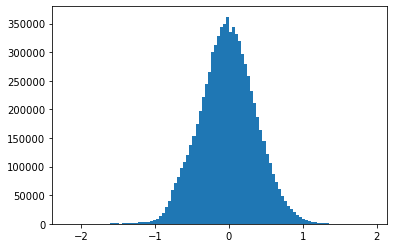

In [50]:
enrich = dat_sub[IP_col] / (dat_sub[input_col] + 1.)
_ = plt.hist(np.log10(enrich[enrich>0]), bins = 100)

In [53]:
(enrich > 3.).mean()

0.09415465885947047

In [6]:
genome = pickle.load(open("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse

In [7]:
pwm_dat = np.load("/gpfs/commons/home/daknowles/apex_seq/pwms.npz")
pwm_names = pwm_dat['names']
pwms = pwm_dat['pwms']

pwms[pwms > 0].min()
log_pwms = np.log(pwms + 1e-4)

# Convert to actual PWM
w = torch.tensor(log_pwms, dtype=torch.float).transpose(0,2)
w_norm = w - w.mean(1,keepdims=True)

w_norm.shape

torch.Size([453, 4, 7])

In [8]:
specific_pwms = w_norm[ np.array([ "HNRNPK" in g for g in pwm_names ]) ]
specific_pwms.shape

torch.Size([5, 4, 7])

In [18]:
bind_all = dat_sub.rename(columns={"hnrnpk-rep1" : "IP_counts", "input-rep1" : "input_counts" })
bind_all

,chrom,start,end,gene,X5,strand,CW30154-hnrnpk,CW30154-input,hnrnpa1-rep1,IP_counts,hnrnpk-rep2,input_counts,input-rep2,rbfox2-rep2
285,chr1,944203,944503,ENSG00000188976.11,.,-,55,218,982,432,283,1868,1533,1749
287,chr1,944303,944603,ENSG00000188976.11,.,-,53,299,1483,532,326,2529,2178,2342
289,chr1,944403,944703,ENSG00000188976.11,.,-,46,257,1460,494,283,2275,1982,2154
291,chr1,944503,944803,ENSG00000188976.11,.,-,39,189,1174,384,212,1672,1564,1580
293,chr1,944603,944903,ENSG00000188976.11,.,-,24,149,917,308,154,1194,1176,1120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13800279,chrM,15447,15747,ENSG00000198727.2,.,+,78292,10783,37243,685023,583759,100210,116039,28846
13800280,chrM,15547,15847,ENSG00000198727.2,.,+,69660,9659,29247,608916,541008,92383,107683,24885
13800281,chrM,15647,15887,ENSG00000198727.2,.,+,64675,9019,23412,567753,514752,86913,101927,22927
13800282,chrM,15747,15887,ENSG00000198727.2,.,+,29685,6007,13815,276546,309839,57881,67280,14521


In [19]:
test_chromosomes = ["chr1"]
test_data = bind_all[ bind_all['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = bind_all[ bind_all['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = bind_all[ bind_all['chrom'].isin( train_chromosomes ) ]

test_data.shape[0] / bind_all.shape[0], validation_data.shape[0] / bind_all.shape[0]

(0.0903495417515275, 0.1534408095723014)

In [89]:
import biophysnn
import bindingdata
reload(biophysnn)
reload(bindingdata)
phys_net = motifscanner.PhysNet(specific_pwms, 
                                max_over_positions = False, 
                                max_over_motifs = False, 
                                seq_len = 300)
check_point_filename = "regression.pt"
train_accs, val_accs, train_aucs, val_aucs =  biophysnn.train_model(phys_net,
                                                                    train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           num_workers = 8,
                                                           regression = True,
                                                           verbose = True, 
                                                           check_point_filename = check_point_filename,
                                                           lr = 0.1)

Epoch 1 took 144.29s. Train loss: 6.0247 acc: 0.0297 auc 0.780. Val loss: 5.1455 acc: 0.4309 auc 0.818. Patience left: 10
Epoch 2 took 146.19s. Train loss: 5.3073 acc: 0.4301 auc 0.807. Val loss: 5.1461 acc: 0.4352 auc 0.818. Patience left: 9
Epoch 3 took 143.52s. Train loss: 5.3046 acc: 0.4336 auc 0.808. Val loss: 5.1616 acc: 0.4362 auc 0.818. Patience left: 8
Epoch 4 took 139.46s. Train loss: 5.3047 acc: 0.4342 auc 0.808. Val loss: 5.1679 acc: 0.4347 auc 0.818. Patience left: 7
Epoch 5 took 140.06s. Train loss: 5.3047 acc: 0.4341 auc 0.808. Val loss: 5.1603 acc: 0.4372 auc 0.819. Patience left: 6
Epoch 6 took 140.50s. Train loss: 5.3043 acc: 0.4343 auc 0.808. Val loss: 5.1429 acc: 0.4372 auc 0.818. Patience left: 10
Epoch 7 took 139.57s. Train loss: 5.3039 acc: 0.4347 auc 0.808. Val loss: 5.1427 acc: 0.4364 auc 0.818. Patience left: 10
Epoch 8 took 139.95s. Train loss: 5.3046 acc: 0.4342 auc 0.808. Val loss: 5.1418 acc: 0.4369 auc 0.818. Patience left: 10
Epoch 9 took 140.44s. Train 

KeyboardInterrupt: 

In [91]:
{k:v for k,v in phys_net.named_parameters() }

{'motif_scale_unc': Parameter containing:
 tensor([-1.0569, -5.2064, -4.0267, -2.8991, -0.4268], device='cuda:0',
        requires_grad=True),
 'motif_offset': Parameter containing:
 tensor([-7.8896, -9.2472, -7.3999, -6.0438, -8.2521], device='cuda:0',
        requires_grad=True),
 'scale_unc': Parameter containing:
 tensor(1.9611, device='cuda:0', requires_grad=True),
 'offset': Parameter containing:
 tensor(-1.1965, device='cuda:0', requires_grad=True)}

In [22]:
phys_net = motifscanner.PhysNet(specific_pwms, 
                                max_over_positions = False, 
                                max_over_motifs = False, 
                                seq_len = 300)
check_point_filename = "regression.pt"
phys_net.load_state_dict(torch.load(check_point_filename))
_, _, val_auc, preds, labels, enrichs  = biophysnn.eval_model(phys_net, validation_data, genome, regression = True)

In [95]:
preds.shape

(1205431,)

In [96]:
enrichs

array([0.27272728, 0.31578946, 0.35435435, ..., 0.484375  , 0.52      ,
       0.55263156], dtype=float32)

In [25]:
scipy.stats.pearsonr(np.exp(preds), enrichs)

(0.46706726075518984, 0.0)

Text(0, 0.5, 'Observed enrichment')

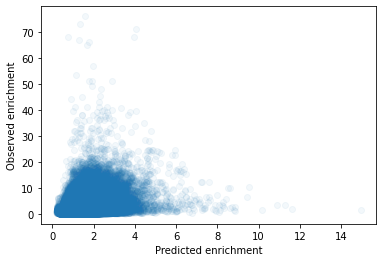

In [26]:
plt.scatter(np.exp(preds), enrichs, alpha=0.05)
plt.xlabel("Predicted enrichment")
plt.ylabel("Observed enrichment")

In [ ]:
sns.kdeplot(np.exp(preds), enrichs)
plt.xlabel("Predicted enrichment")
plt.ylabel("Observed enrichment")

<ipython-input-60-3515f55d9f21>:1: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(np.exp(preds)), np.log2(enrichs), color = "black", alpha=0.005) # separate by gene regions


Text(0, 0.5, 'log2 Observed enrichment')

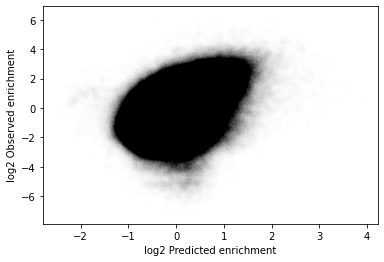

In [60]:
plt.scatter(np.log2(np.exp(preds)), np.log2(enrichs), color = "black", alpha=0.005) # separate by gene regions
plt.xlabel("log2 Predicted enrichment")
plt.ylabel("log2 Observed enrichment")

Text(0, 0.5, 'Observed enrichment')

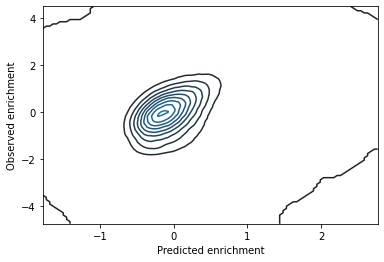

In [39]:
sns.kdeplot(preds, np.log(enrichs + 0.01))
plt.xlabel("Predicted enrichment")
plt.ylabel("Observed enrichment")

## Correlate enrichments

In [42]:
dat

,chrom,start,end,gene,X5,strand,CW30154-hnrnpk,CW30154-input,hnrnpa1-rep1,hnrnpk-rep1,hnrnpk-rep2,input-rep1,input-rep2,rbfox2-rep2
0,chr1,65419,65719,ENSG00000186092.7,.,+,0,0,0,0,0,0,0,0
1,chr1,65519,65819,ENSG00000186092.7,.,+,0,0,0,0,0,0,0,0
2,chr1,65619,65919,ENSG00000186092.7,.,+,0,0,0,0,0,0,0,0
3,chr1,65719,66019,ENSG00000186092.7,.,+,0,0,0,0,0,0,0,0
4,chr1,65819,66119,ENSG00000186092.7,.,+,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13800279,chrM,15447,15747,ENSG00000198727.2,.,+,78292,10783,37243,685023,583759,100210,116039,28846
13800280,chrM,15547,15847,ENSG00000198727.2,.,+,69660,9659,29247,608916,541008,92383,107683,24885
13800281,chrM,15647,15887,ENSG00000198727.2,.,+,64675,9019,23412,567753,514752,86913,101927,22927
13800282,chrM,15747,15887,ENSG00000198727.2,.,+,29685,6007,13815,276546,309839,57881,67280,14521


In [49]:
dat_all = dat[(dat["input-rep1"] > 15) & (dat["input-rep2"] > 15)].copy()

In [50]:
dat_all["hnrnpk_enrich_1"] = dat["hnrnpk-rep1"] / dat["input-rep1"]
dat_all["hnrnpk_enrich_2"] = dat["hnrnpk-rep2"] / dat["input-rep2"]
dat_all["hnrnpa1_enrich"] = dat["hnrnpa1-rep1"] / dat["input-rep1"]
dat_all["rbfox2_enrich"] = dat["rbfox2-rep2"] / dat["input-rep2"]

,hnrnpk_enrich_1,hnrnpk_enrich_2,hnrnpa1_enrich,rbfox2_enrich
285,0.231263,0.184605,0.525696,1.140900
287,0.210360,0.149679,0.586398,1.075298
289,0.217143,0.142785,0.641758,1.086781
291,0.229665,0.135550,0.702153,1.010230
293,0.257956,0.130952,0.768007,0.952381
...,...,...,...,...
13800279,6.835875,5.030714,0.371650,0.248589
13800280,6.591213,5.024080,0.316584,0.231095
13800281,6.532429,5.050203,0.269373,0.224935
13800282,4.777837,4.605217,0.238679,0.215829


In [54]:
cor_mat = np.corrcoef(dat_all.iloc[:,-4:].to_numpy().transpose())

<AxesSubplot:>

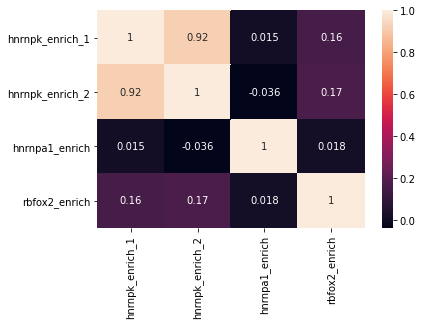

In [56]:
sns.heatmap(dat_all.iloc[:,-4:].corr(), annot=True)

In [57]:
specific_pwms.shape

torch.Size([5, 4, 7])